## Loading the data

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import pydotplus

from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from six import StringIO
from IPython.display import Image

In [99]:
# @title data prep
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_reshaped = x_train.reshape(-1, 28 * 28).astype(np.float32)
x_test_reshaped = x_test.reshape(-1, 28 * 28).astype(np.float32)

train_df = pd.DataFrame(x_train_reshaped)
train_df["label"] = y_train
test_df = pd.DataFrame(x_test_reshaped)
test_df["label"] = y_test
concat_df = pd.concat([train_df, test_df])

features = range(784)

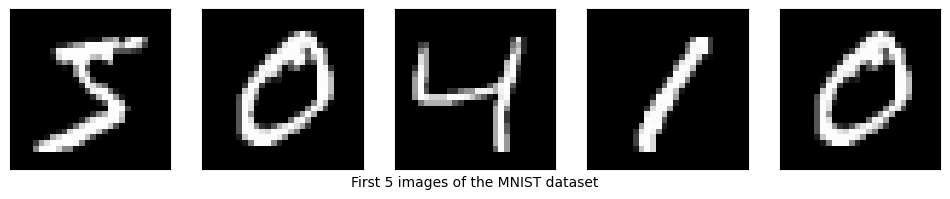

In [100]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 5, figure=fig) 

axs = [fig.add_subplot(gs[i]) for i in range(5)]


for i in range(5):
    axs[i].imshow(x_train[i], cmap='gray', interpolation='none')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    if i == 2:
        axs[i].set_xlabel("First 5 images of the MNIST dataset")

plt.imshow(x_train[1], cmap="gray")
plt.show()

In [101]:
concat_df.head()

0    1    2    3    4    5    6    7    8    9  ...  775  776  777  778  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   779  780  781  782  783  label  
0  0.0  0.0  0.0  0.0  0.0      5  
1  0.0  0.0  0.0  0.0  0.0      0  
2  0.0  0.0  0.0  0.0  0.0      4  
3  0.0  0.0  0.0  0.0  0.0      1  
4  0.0  0.0  0.0  0.0  0.0      9  

[5 rows x 785 columns]

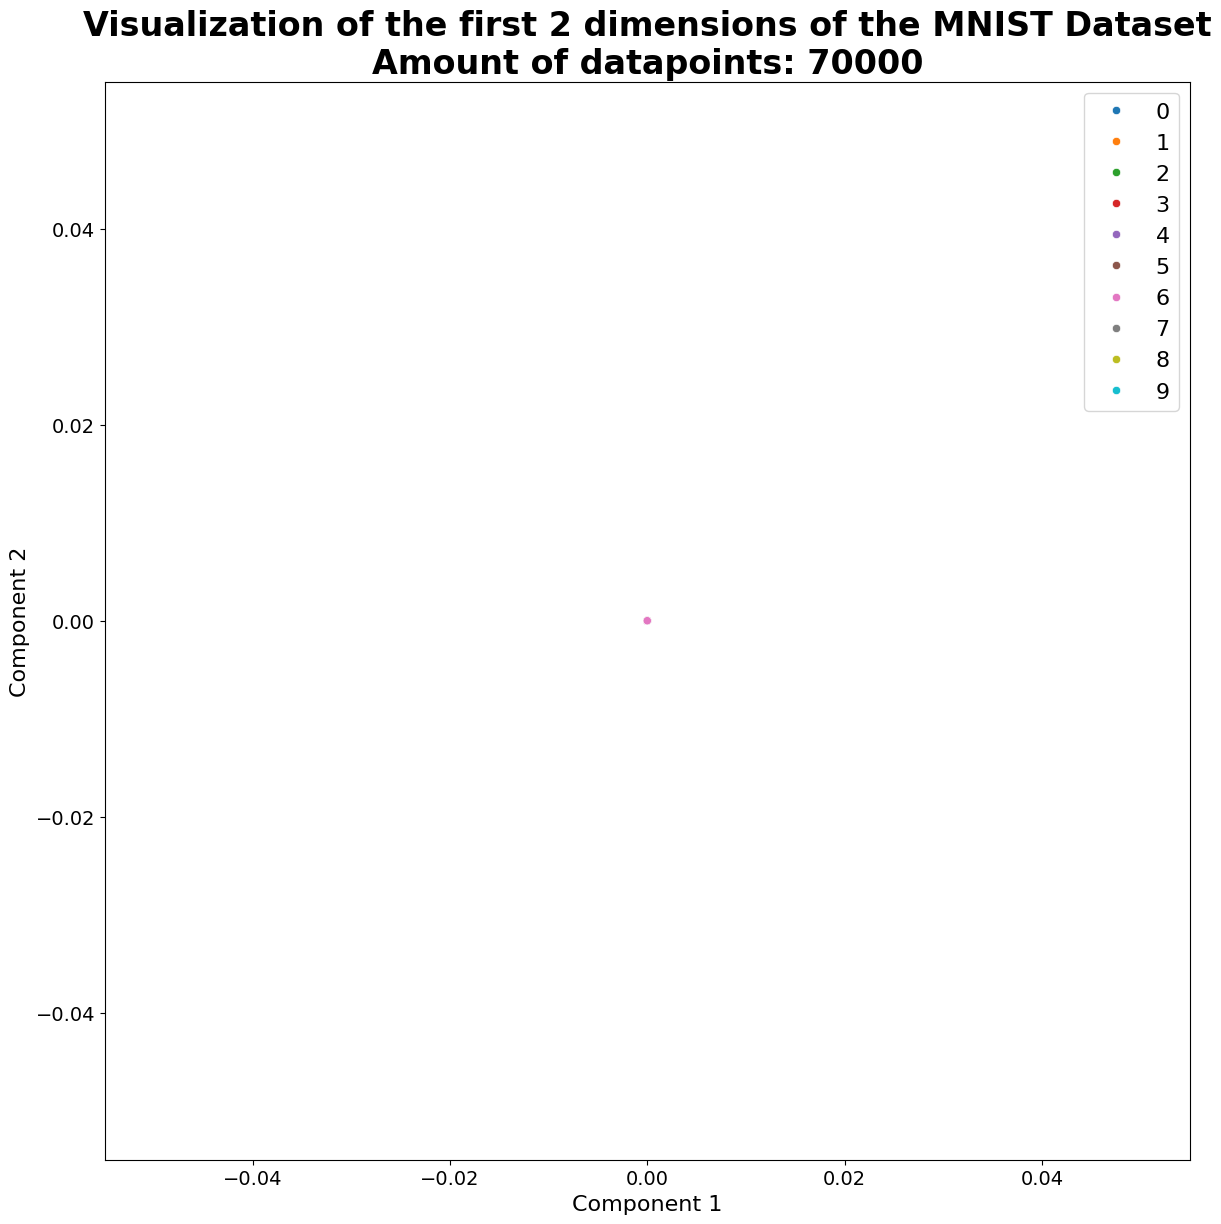

In [114]:
plt.figure(figsize=(14, 14))
plt.title(
    f"Visualization of the first 2 dimensions of the MNIST Dataset\n\
Amount of datapoints: {len(concat_df)}",
    fontsize=24,
    weight="bold",
)

pallete = sns.color_palette("tab10", 10)

sns.scatterplot(
    data=concat_df,
    hue="label",
    x=0,
    y=1,
    palette=pallete,
    legend="full",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16)

## Simple tree classifier

In [103]:
def acc(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates the accuracy score between labels and predictions.

    :param y_true: The true labels of the data
    :param y_pred: The predictions for the data

    :return: a floating point number denoting the accuracy
    """
    return np.round(accuracy_score(y_true, y_pred) * 100, 2)

def get_acc(clf, data, x, y):
    """
    Computes the accuracy of a classifier's predictions.

    This function applies a trained classifier to a subset of data, compares the predicted labels 
    to the actual labels, and calculates the accuracy of these predictions.

    :param clf: The classifier used for making predictions. The classifier should already be trained
                and should implement a `predict` method.
    :param data: A pandas DataFrame containing the dataset with features and labels.
    :param x: The column name or list of column names in `data` used as features for making predictions.
    :param y: The column name in `data` that contains the true labels.
    
    :return: A float representing the accuracy percentage of the classifier's predictions on the 
             provided data, rounded to two decimal places.
    """
    predictions = clf.predict(data[x])
    accuracy = acc(predictions, data[y])
    
    return accuracy

In [104]:
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(train_df[features], train_df["label"])

DecisionTreeClassifier(max_depth=10, random_state=42)

In [105]:
baseline = get_acc(clf, train_df, features, 'label')
validation = get_acc(clf, test_df, features, 'label')
print(f"Test accuracy for our baseline (using all pixel): {baseline}%")
print(f"Validation accuracy for our baseline (using all pixel): {validation}%")

Test accuracy for our baseline (using all pixel): 89.95%
Validation accuracy for our baseline (using all pixel): 86.62%


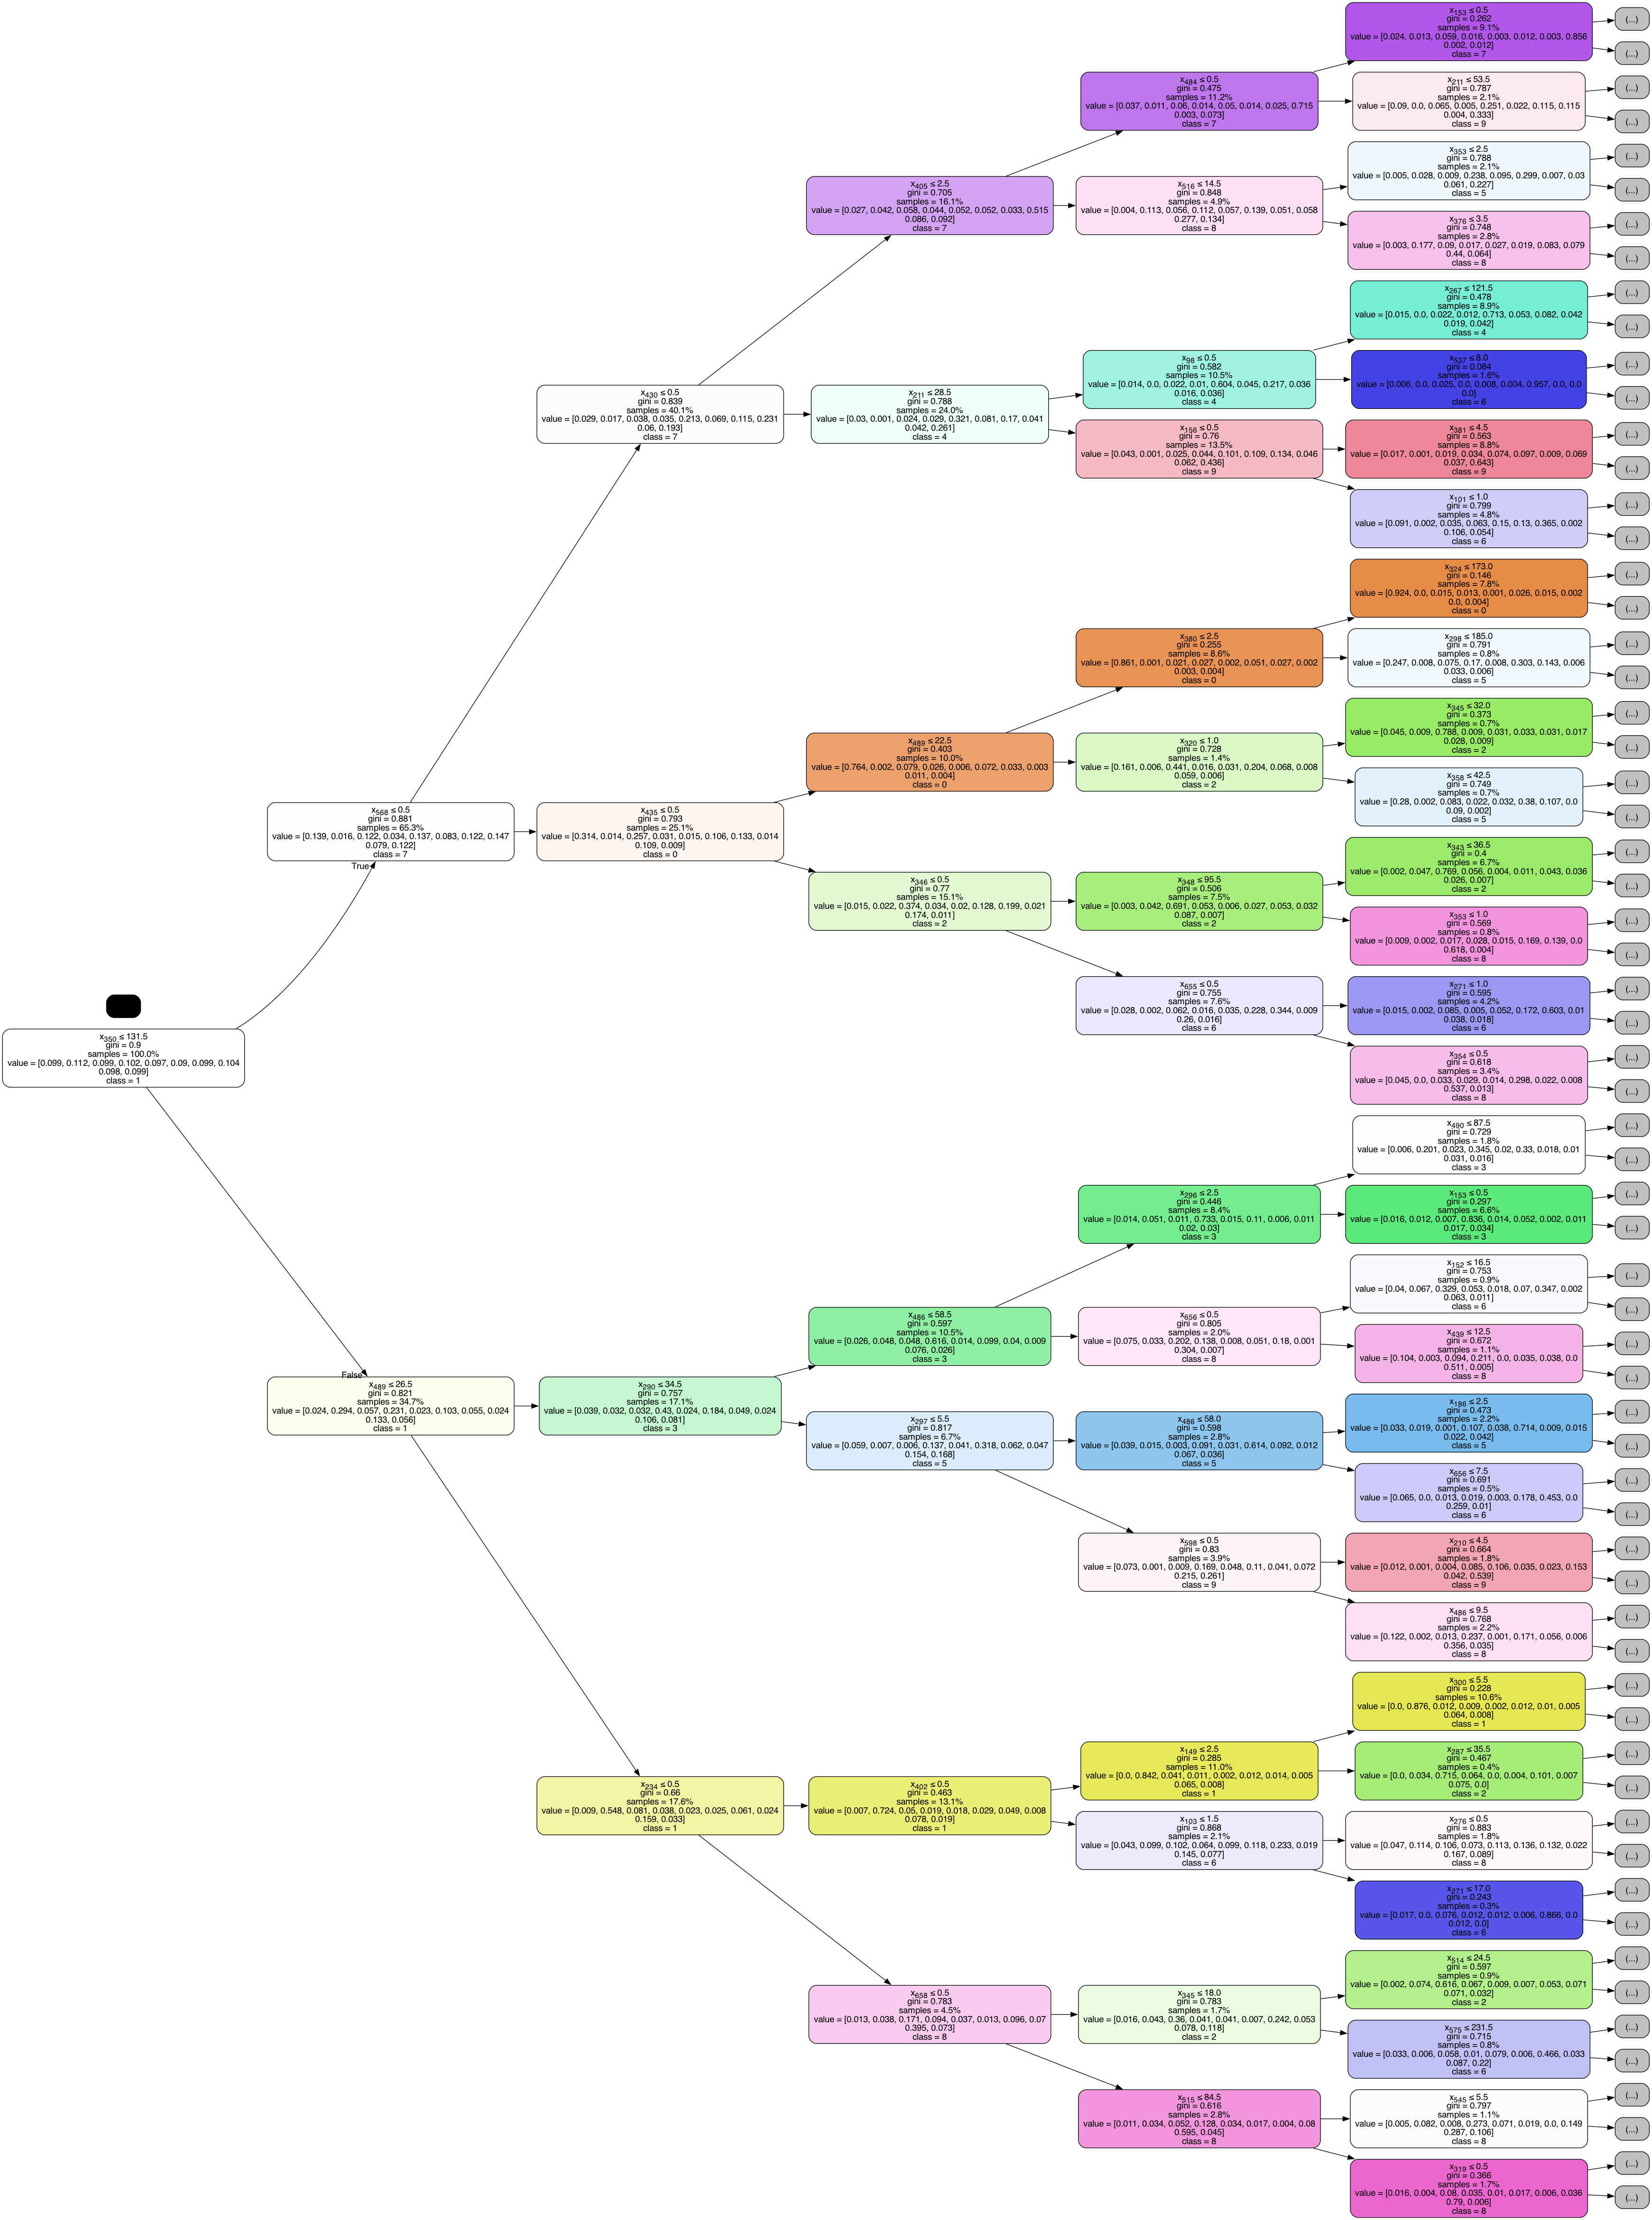

In [119]:
dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=5,
    proportion=True,
    class_names=[str(i) for i in range(10)],
    rotate=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Create PNG file
Image(graph.create_png())

## With SVD

### Step 1 - Choose dimension of K

In [107]:
S = TruncatedSVD(n_components=784).fit(concat_df[features]).singular_values_

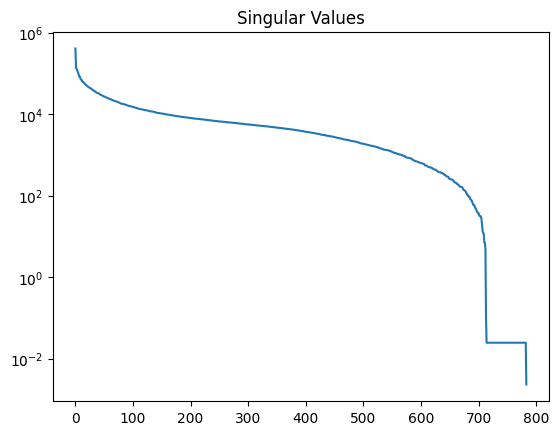

In [108]:
plt.plot(S)
plt.title("Singular Values")
plt.yscale("log")
plt.show()

### Step 2 - Run classifier for k = 50

In [109]:
# running svd on train + test
tsvd = TruncatedSVD(n_components=50).fit_transform(concat_df[features])

In [110]:
tsvd_features = [f"component_{i+1}" for i in range(50)]
tsvd_df = pd.DataFrame(tsvd, columns=tsvd_features)
tsvd_df["label"] = concat_df["label"].values

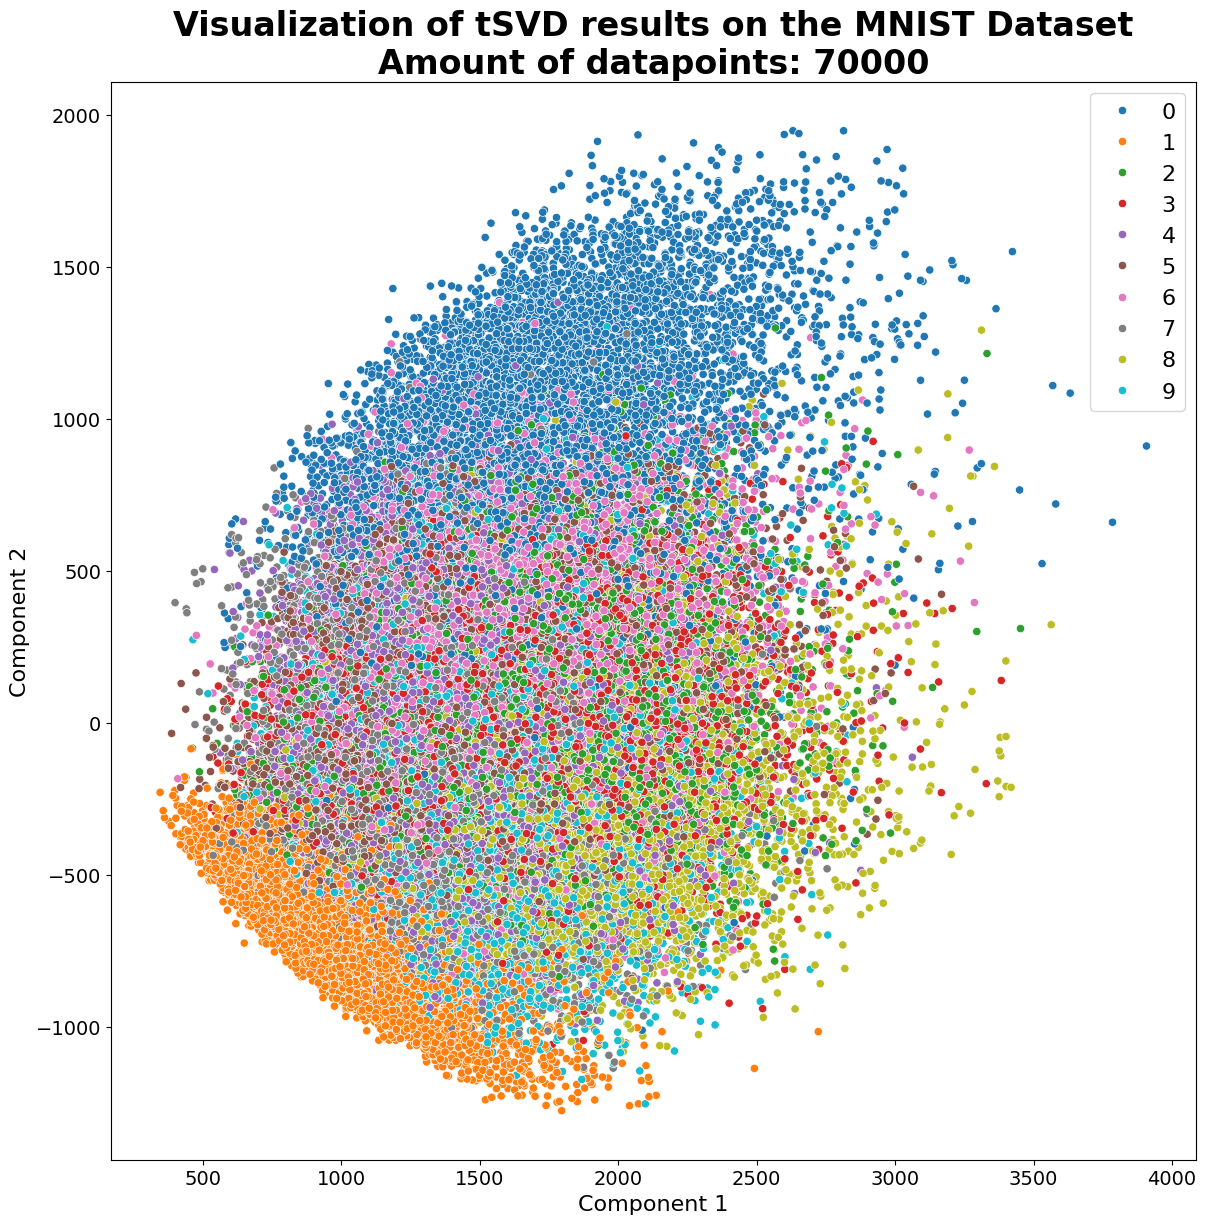

In [111]:
plt.figure(figsize=(14, 14))
plt.title(
    f"Visualization of tSVD results on the MNIST Dataset\n\
Amount of datapoints: {len(tsvd)}",
    fontsize=24,
    weight="bold",
)

pallete = sns.color_palette("tab10", 10)

sns.scatterplot(
    data=tsvd_df,
    hue="label",
    x="component_1",
    y="component_2",
    palette=pallete,
    legend="full",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16)

In [112]:
x_train, x_validation, y_train, y_validation = train_test_split(
    tsvd_df[tsvd_features], tsvd_df["label"], test_size=0.2, random_state=42
)

svd_train_df = x_train.assign(label=y_train)
svd_validation_df = x_validation.assign(label=y_validation)

In [41]:
clf_tsvd = DecisionTreeClassifier(max_depth=10, random_state=42).fit(x_train, y_train)

In [42]:
baseline = get_acc(clf_tsvd, svd_train_df, tsvd_features, 'label')
validation = get_acc(clf_tsvd, svd_validation_df, tsvd_features, 'label')
print(f"Test accuracy for our baseline (using all pixel): {baseline}%")
print(f"Validation accuracy for our baseline (using all pixel): {validation}%")

Test accuracy for our baseline (using all pixel): 84.54%
Validation accuracy for our baseline (using all pixel): 80.37%


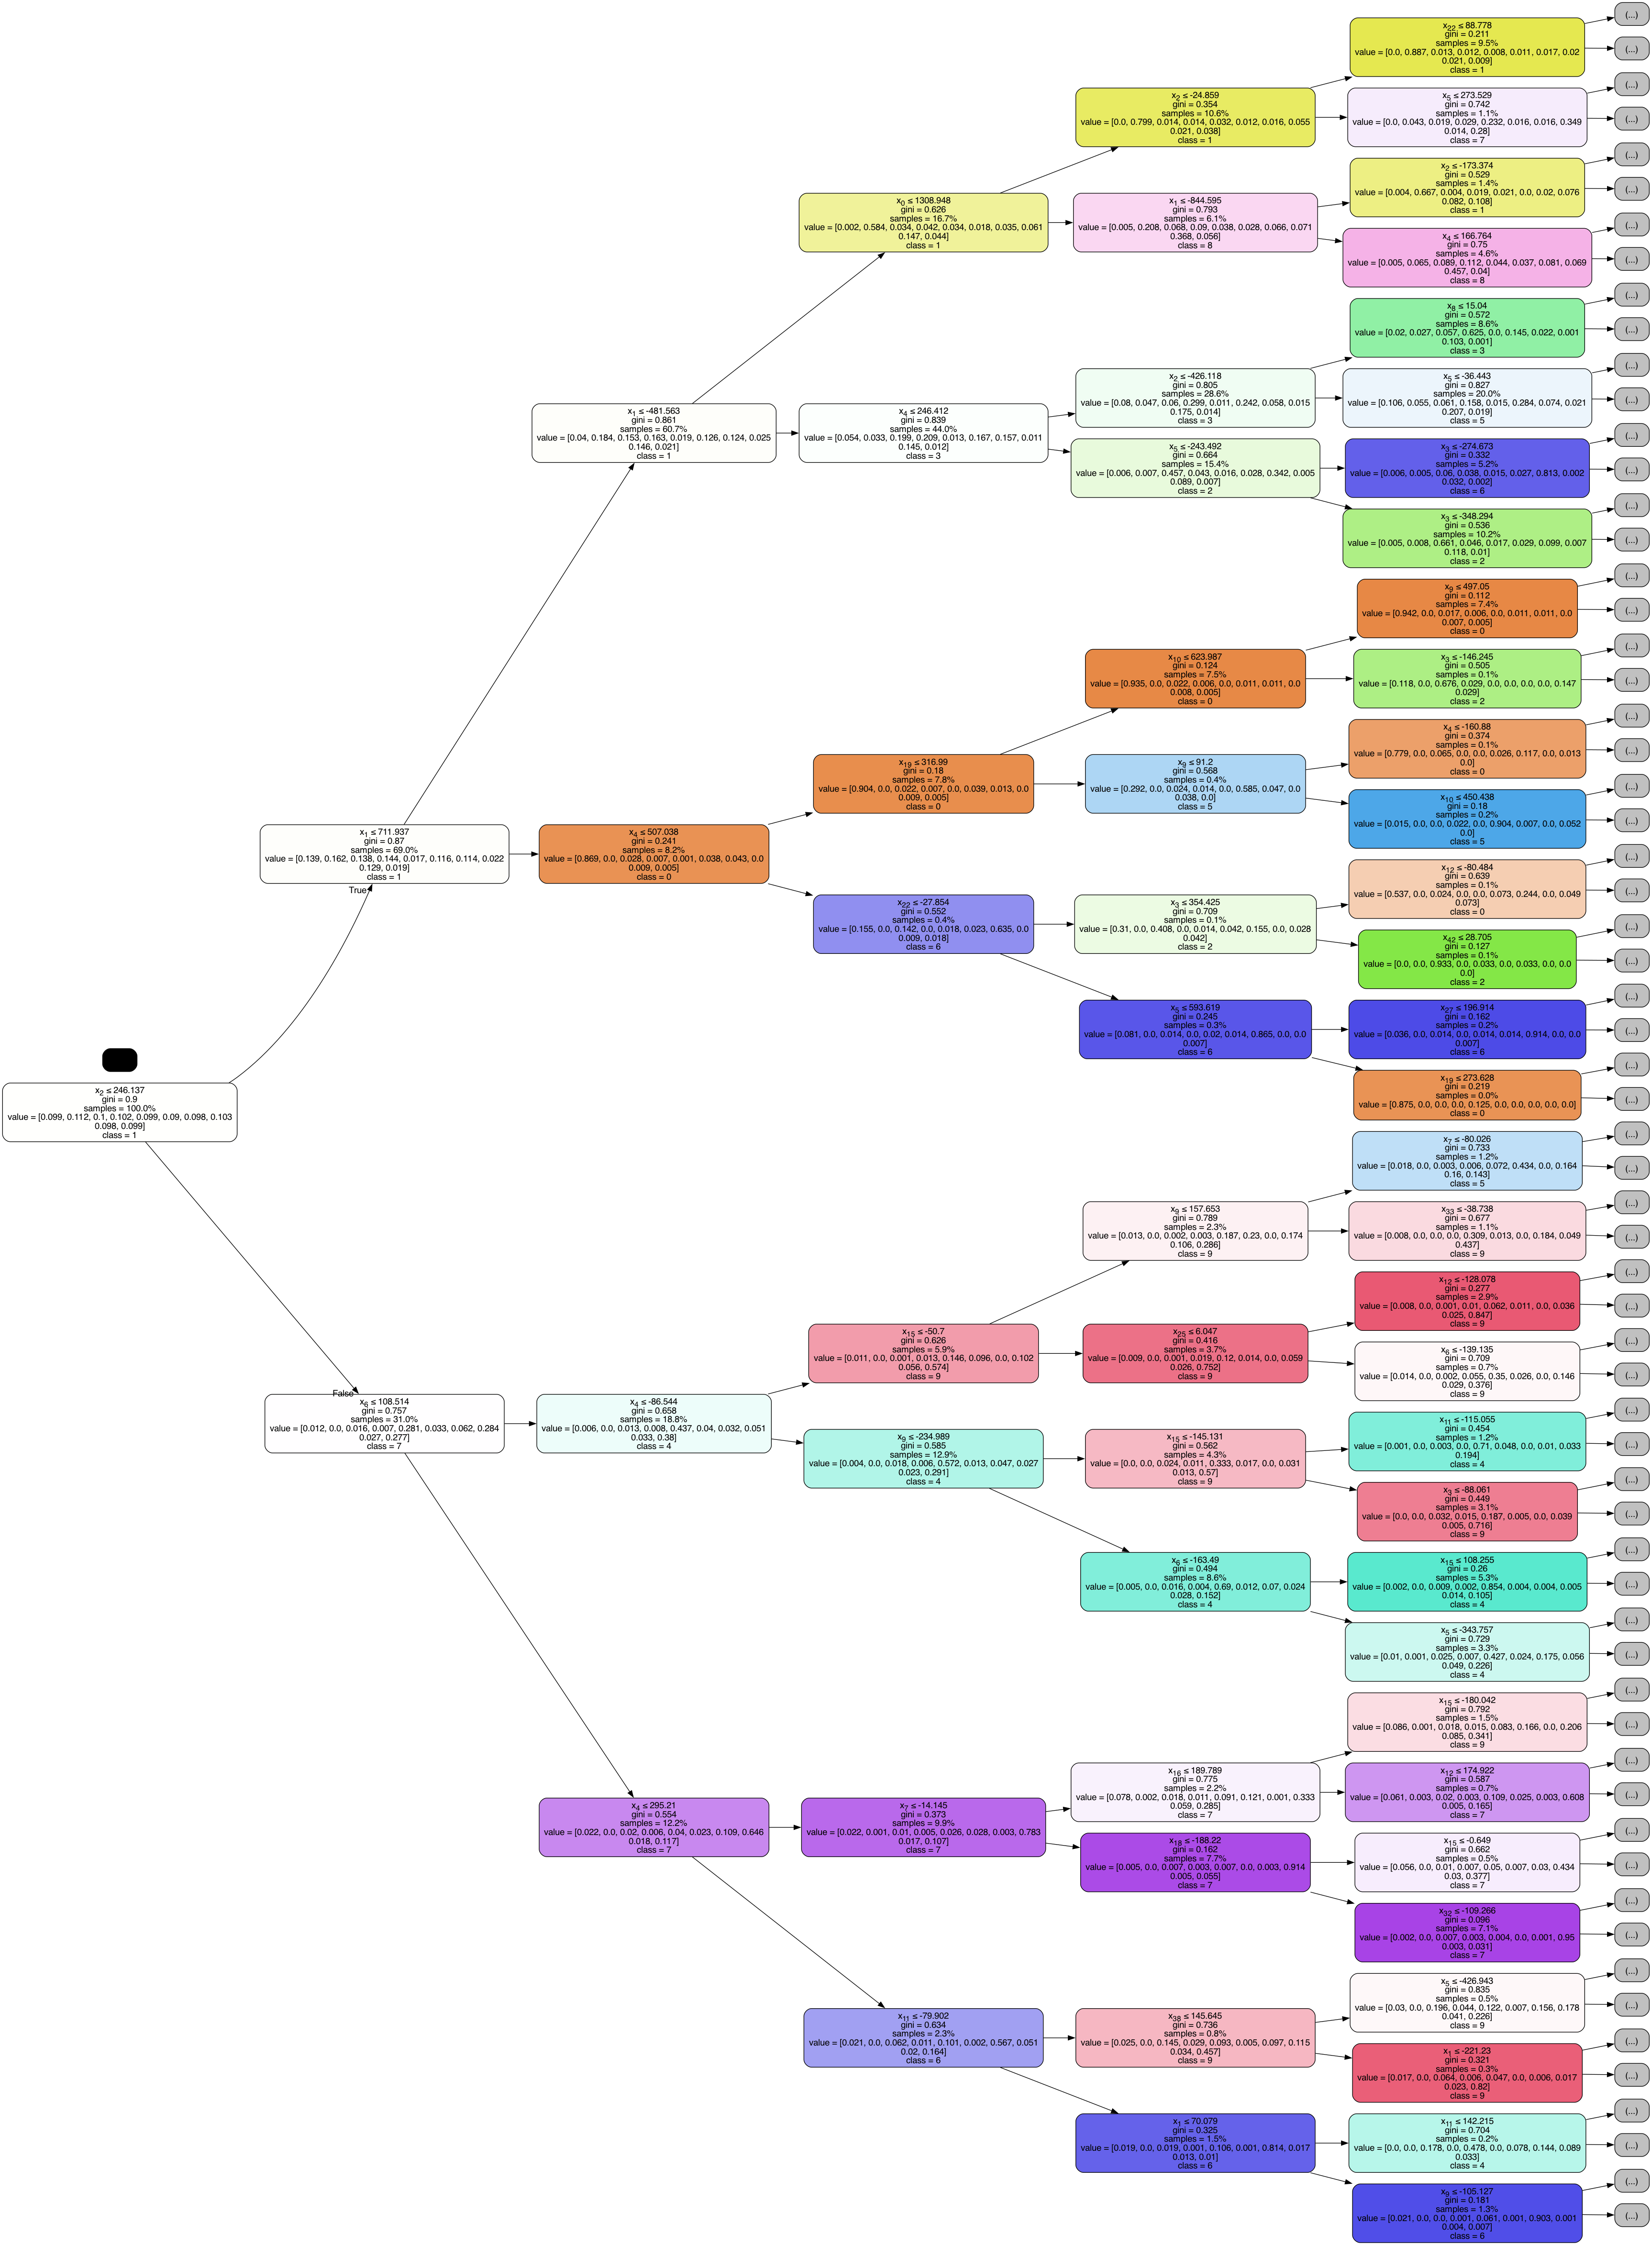

In [120]:
dot_data = StringIO()
export_graphviz(
    clf_tsvd,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=5,
    proportion=True,
    class_names=[str(i) for i in range(10)],
    rotate=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Create PNG file
Image(graph.create_png())

## With t-SNE

### Step 1 - Apply T-SNE on SVD Matrix

In [44]:
tsne = TSNE().fit_transform(tsvd)

In [49]:
tsne_features = ["component1", "component2"]
tsne_df = pd.DataFrame(tsne, columns=tsne_features).assign(label=tsvd_df["label"])

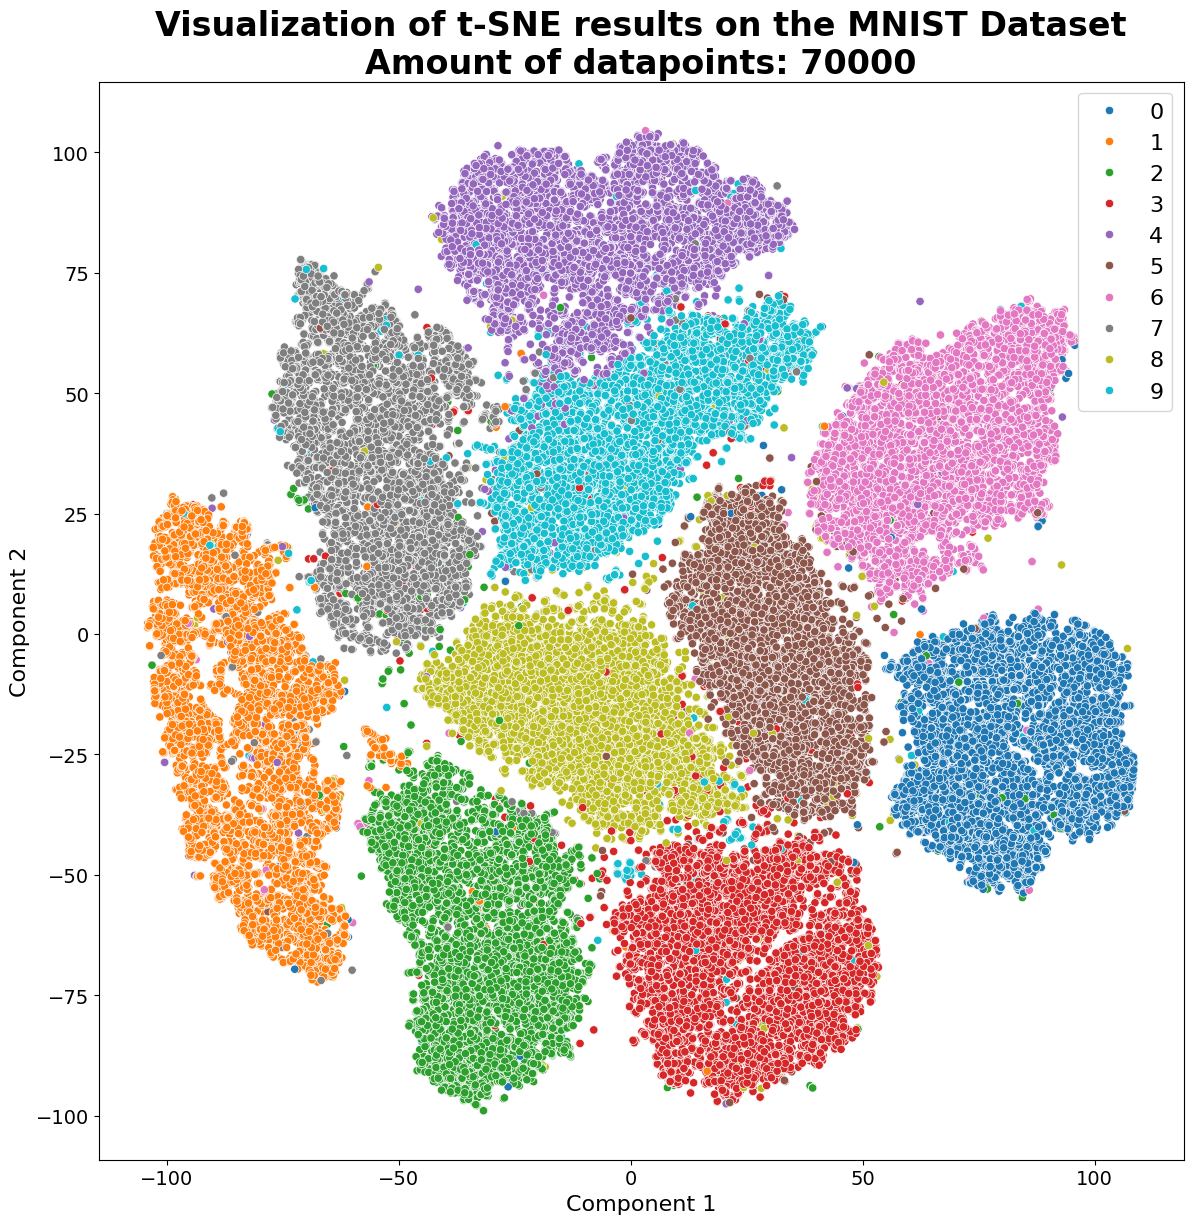

In [113]:
plt.figure(figsize=(14, 14))
plt.title(
    f"Visualization of t-SNE results on the MNIST Dataset\n\
Amount of datapoints: {len(tsne_df)}",
    fontsize=24,
    weight="bold",
)
pallete = sns.color_palette("tab10", 10)

sns.scatterplot(
    data=tsne_df,
    x="component1",
    y="component2",
    hue="label",
    palette=pallete,
    legend="full",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16)

In [51]:
x_train, x_validation, y_train, y_validation = train_test_split(
    tsne_df[tsne_features], tsne_df["label"], test_size=0.2, random_state=42
)

tsne_train_df = x_train.assign(label=y_train)
tsne_validation_df = x_validation.assign(label=y_validation)

In [52]:
clf_tsne = DecisionTreeClassifier(max_depth=10, random_state=42).fit(x_train, y_train)

In [56]:
baseline = get_acc(clf_tsne, tsne_train_df, tsne_features, 'label')
validation = get_acc(clf_tsne, tsne_validation_df, tsne_features, 'label')
print(f"Test accuracy for our baseline (using all pixel): {baseline}%")
print(f"Validation accuracy for our baseline (using all pixel): {validation}%")

Test accuracy for our baseline (using all pixel): 97.68%
Validation accuracy for our baseline (using all pixel): 96.92%


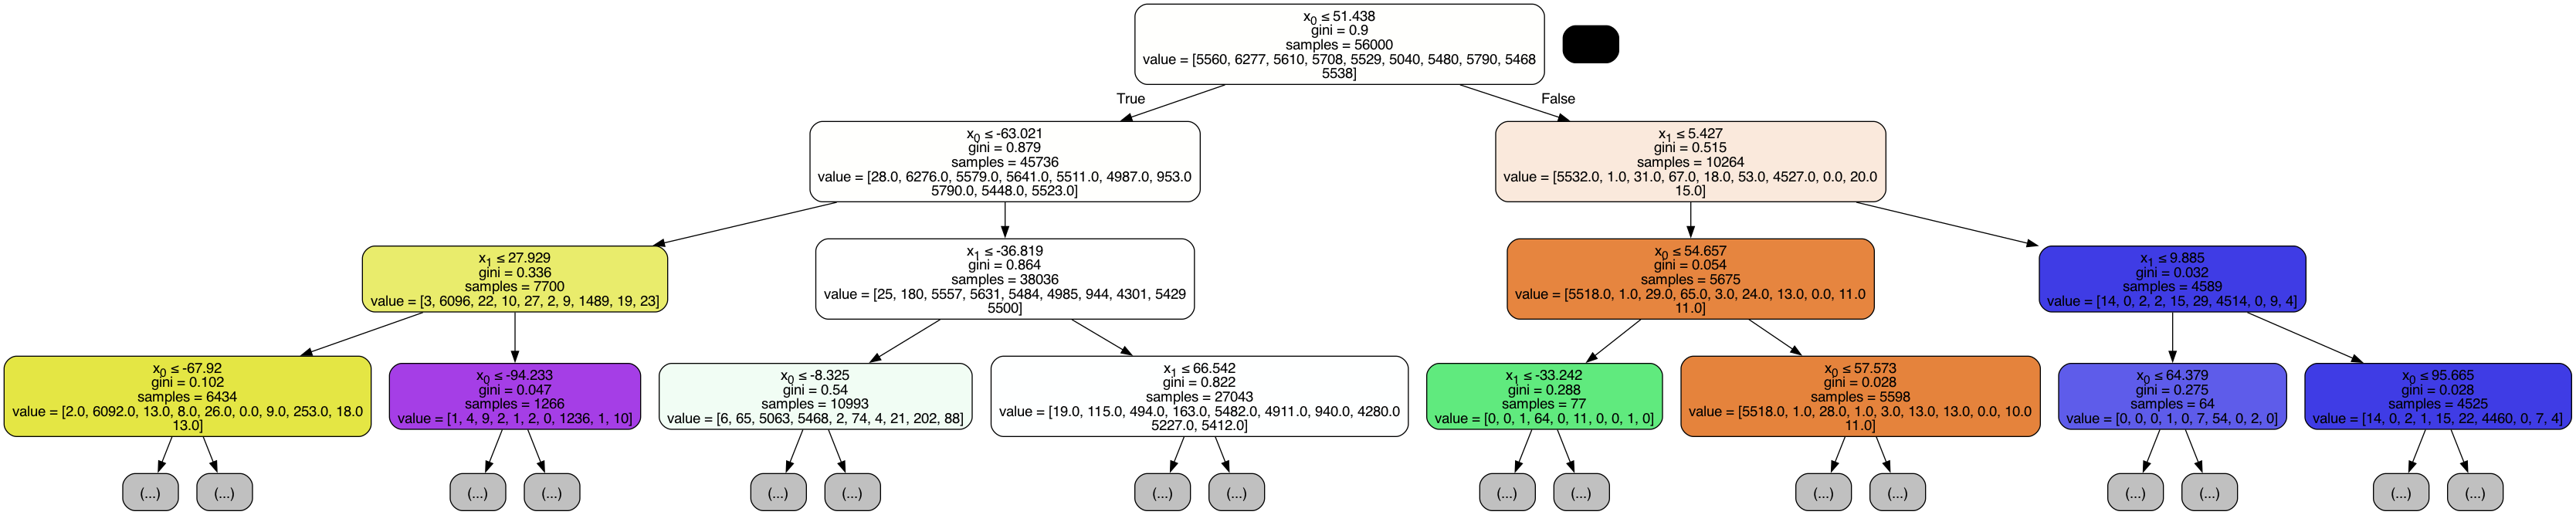

In [57]:
dot_data = StringIO()
export_graphviz(
    clf_tsne,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Create PNG file
Image(graph.create_png())